# Appendix

# Q4

#### Importing module & packages

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

#### Reading images into list

In [4]:
trainDataPath = "./emotion_classification/train"  # train data path
testDataPath = "./emotion_classification/test"  # test data path
trainDataList = os.listdir(trainDataPath) # creates list of train image data 
testDataList = os.listdir(testDataPath)   # creates list of test data path

#### Converting the list of image file name to list of image in array form

In [227]:
train_array=[] 
for i in range(0,len(trainDataList)):
    img_path = os.path.join(trainDataPath,trainDataList[i])
    temp = plt.imread(img_path,0)
    train_array.append(temp)
    
test_array=[]
for i in range(0,len(testDataList)):
    img_path = os.path.join(testDataPath,testDataList[i])
    temp = plt.imread(img_path,0)
    test_array.append(temp)

#### Data Matrix function 

In [5]:
def DataMatrix(list_img_arr):
    """This function create a data matrix of R^(NxD) dimension"""
    data_matrix_list=[] 
    
    for img in list_img_arr:
        data_matrix_list.append(img.flatten())
        
    data_matrix_arr = np.array(data_matrix_list)
    return data_matrix_arr

#### Centre Data Matrix fucntion

In [229]:
def CentreDataMatrix(X_mat):
    """This function centres the data matrix around it's mean"""
    mean_vec = X_mat.mean(axis=0)
    X_mat = X_mat - mean_vec
    return X_mat

#### Training PCA

In [230]:
def TrainPCA(X, n, k):
    
    S = (1/n)*(X@X.T) # co-variance matrix    
    eigVal, eigVec = np.linalg.eig(S) # eigen decomposition of co-variance matrix
    index = eigVal.argsort()[::-1]   # sorted eigen values index in decreasing order    
    eigVal = eigVal[index] # sorted eigen values
    eigVec = eigVec[:,index] # eigen vec. corresponding to sorted eigen values   
    u = (X.T@eigVec[:,:k])/(np.sqrt(eigVal[:k]*n))
    return u

#### Class label extraction from the list of image file name

In [231]:
def ExtractClassLabel(ImgDataList):
    classLabel = []
    for i in ImgDataList:
        if "happy" in i:
            classLabel.append("happy")
        else:
            classLabel.append("sad")
    return classLabel

#### Training LDA

In [232]:
def TrainLDA(y, happyIdx, sadIdx, k): 
    
    happyDataMatrix = y[happyIdx,:]
    sadDataMatrix = y[sadIdx,:]
    
    happyMean = happyDataMatrix.mean(axis=0)
    sadMean = sadDataMatrix.mean(axis=0)
    yMean = y.mean(axis=0)

    x1 = (happyMean - yMean).reshape(k,1)
    x2 = (sadMean - yMean).reshape(k,1)

    Sb = len(happyIdx)*x1@x1.T + len(sadIdx)*x2@x2.T
    Sw = (happyDataMatrix - happyMean).T@(happyDataMatrix - happyMean) + \
    (sadDataMatrix - sadMean).T@(sadDataMatrix - sadMean)
    Soverall = np.linalg.inv(Sw)@Sb
    
    eVal, eVec = np.linalg.eig(Soverall)
    largestEigValIdx = np.argmax(eVal)
    largestEigVec = eVec[:,largestEigValIdx]
    
    return largestEigVec.real

#### Main Program

In [233]:
d = 12
N = len(trainDataList) 

Xtrain = DataMatrix(train_array)
centered_Xtrain = CentreDataMatrix(Xtrain)
U = TrainPCA(centered_Xtrain, N, d)

# ouput of PCA on training data
yTrain_PCA = centered_Xtrain@U

Xtrain_target = ExtractClassLabel(trainDataList)

happyTrainIdx = [i for i in range(0,len(Xtrain_target)) if Xtrain_target[i] == "happy"]
sadTrainIdx = [i for i in range(0,len(Xtrain_target)) if Xtrain_target[i] == "sad"]

happyTrainDataMatrix = yTrain_PCA[happyTrainIdx,:]
sadTrainDataMatrix = yTrain_PCA[sadTrainIdx,:]

# calculating w from the LDA
W= TrainLDA(yTrain_PCA, happyTrainIdx, sadTrainIdx, d)

# output of LDA for both happy and sad class
yTrain_Happy_LDA = happyTrainDataMatrix@W
yTrain_Sad_LDA = sadTrainDataMatrix@W

# threshold value calculated from tarining data
thresholdValue = (yTrain_Happy_LDA.max() + yTrain_Sad_LDA.min())/2 

#### Analysis on training data

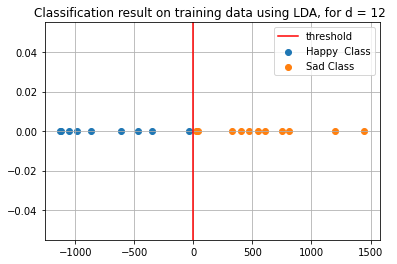

In [234]:
# Train data classification plot
plt.scatter(yTrain_Happy_LDA, np.zeros(len(happyTrainIdx)), label = "Happy  Class")
plt.scatter(yTrain_Sad_LDA, np.zeros(len(sadTrainIdx)), label = "Sad Class")
plt.axvline(x = thresholdValue, color = 'r', label = 'threshold')
plt.grid()
plt.title(f"Classification result on training data using LDA, for d = {d} ")
plt.legend()
plt.show()

#### Analysis on Test Data 

In [235]:
# computing centred test data
Xtest = DataMatrix(test_array)
Xtest_target = ExtractClassLabel(testDataList)
centered_Xtest = Xtest - Xtrain.mean(axis=0)

yTest_PCA = centered_Xtest@U
YTest_LDA = yTest_PCA@W
YTest_LDA

predLabel = []

# assigning label 
for i in YTest_LDA:
    if i>thresholdValue:
        predLabel.append("sad")
    else:
        predLabel.append("happy")

# checking no. of miss-classification for test data
misclassificationCount = 0
for i in range(0,len(predLabel)):
    if predLabel[i]==Xtest_target[i]:
        continue
    else:
        misclassificationCount = misclassificationCount+1 
        
predHappyClass = YTest_LDA[np.array(predLabel)=='happy']
predSadClass = YTest_LDA[np.array(predLabel)=='sad']

print(f"No. of misclassification observed on test data = {misclassificationCount}")

No. of misclassification observed on test data = 0


#### Classification plot on test data

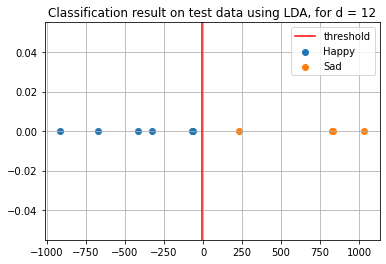

In [236]:
# test data classification plot
plt.scatter(predHappyClass, np.zeros(len(predHappyClass)), label = "Happy")
plt.scatter(predSadClass, np.zeros(len(predSadClass)), label = "Sad")
plt.axvline(x = thresholdValue, color = 'r', label = 'threshold')
plt.grid()
plt.title(f"Classification result on test data using LDA, for d = {d}")
plt.legend()
plt.show()